## LIBRARY IMPORT


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Patch
import seaborn as sns
from scipy.stats import entropy
import pyhomogeneity as hg
import pymannkendall as mk
from statsmodels.tsa.stattools import adfuller, bds
from statsmodels.graphics.tsaplots import plot_acf
from tabulate import tabulate

In [5]:
plt.rcParams.update({
    'figure.figsize': (16, 9),
    'lines.linewidth': 2,
    'lines.color': 'royalblue',
    'axes.labelsize': 14,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'axes.titleweight': 'bold',
    'grid.linestyle': '--'
})

In [6]:
df = pd.DataFrame(pd.read_csv("../data/raw/Precipitation_complete.csv"))

In [55]:
def display_results_table(results_dict, title):
    print(f"\n{title}")
    print("=" * 50)
    table_data = [(key, value) for key, value in results_dict.items()]
    print(tabulate(table_data, headers=["Parameter", "Value"], tablefmt="grid"))
    print()

## Trend and level

In [63]:
def analyze_trend(data_series, alpha=0.01):
    mk_result = mk.original_test(data_series, alpha=alpha)

    trend_results = pd.Series({
        'Trend': mk_result.trend,
        'p-value': mk_result.p,
        'Slope': mk_result.slope,
        'Intercept': mk_result.intercept,
        'Test Statistic': getattr(mk_result, 's', 'N/A'),
        'Variance S': getattr(mk_result, 'var_s', 'N/A'),
        'Alpha': alpha
    })

    # Mann-Kendall test result
    slope = mk_result.slope
    intercept = mk_result.intercept

    # Calculate the trend line
    trend_line = slope * np.arange(len(data_series)) + intercept
    level = np.full(len(data_series), data_series.mean())
    
    # Plotting
    plt.plot(np.arange(len(data_series)), data_series, label='precipitation', color='royalblue')
    plt.plot(np.arange(len(data_series)), trend_line, label='trend line', color='orange', linestyle='--', lw=2.5)
    plt.plot(np.arange(len(data_series)), level, label='level', color='green', linestyle='--', lw=2.5)

    plt.title('Trend analysis', fontsize=18)
    plt.xlabel('Sample index', fontsize=14)
    plt.ylabel('Precipitation (mm)', fontsize=14)
    plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    return trend_results

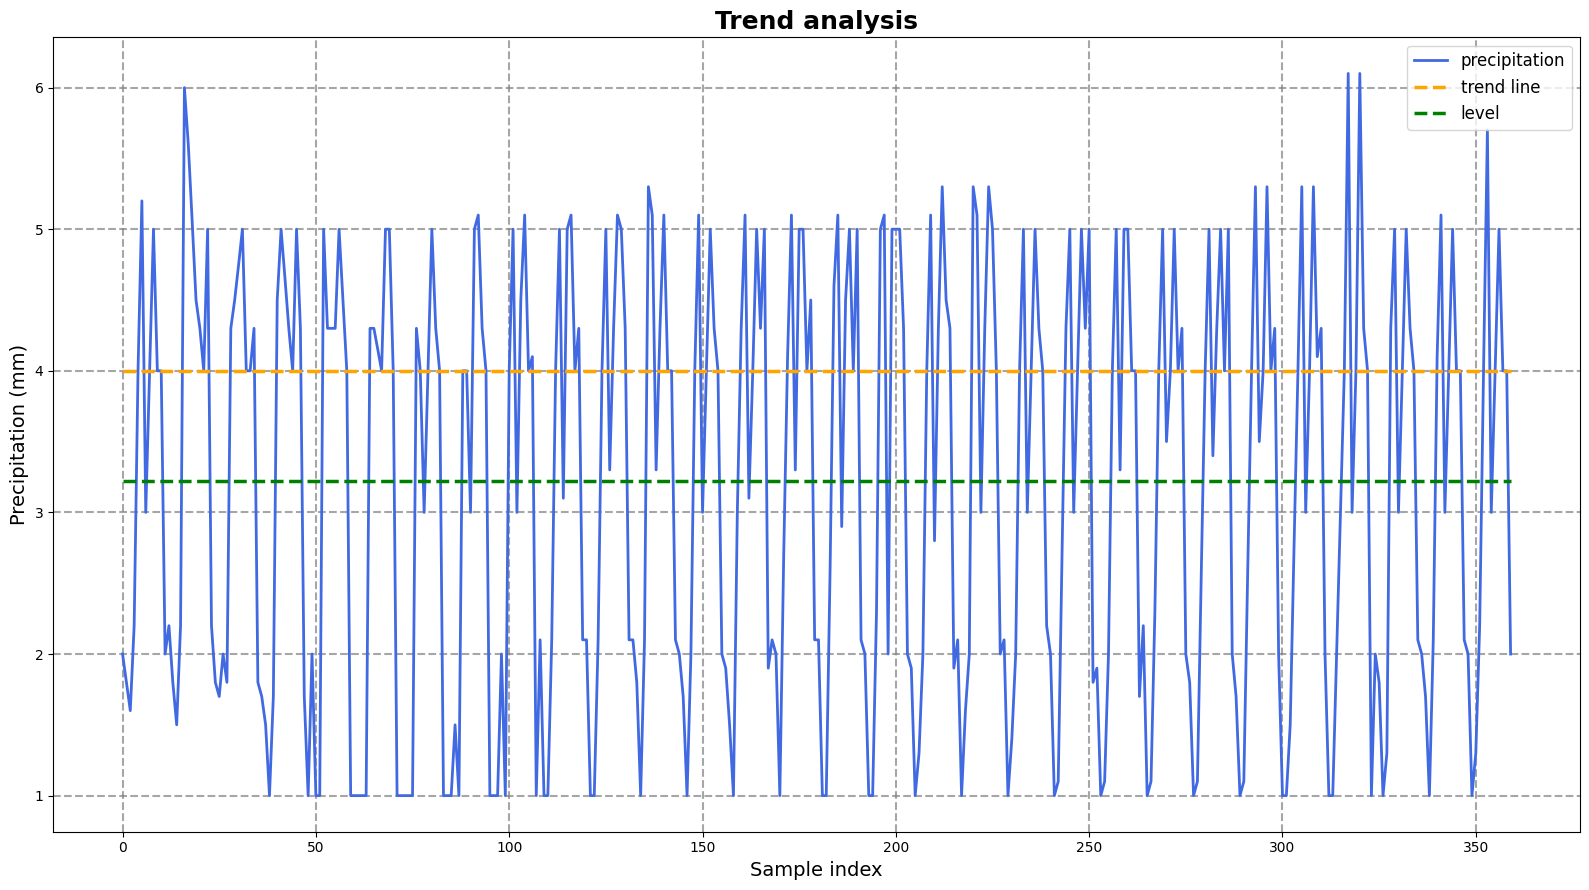

Trend                   no trend
p-value                 0.872859
Slope                        0.0
Intercept                    4.0
Test Statistic             364.0
Variance S        5145443.333333
Alpha                       0.01
dtype: object

In [64]:
analyze_trend(df['precipitation'])

**General Interpretation**:
The test shows that there is no significant trend in the data (`no trend`), the p-value is high, and the slope is `0.0`, which confirms that the values are not significantly increasing or decreasing over time. This indicates stability or absence of a directional pattern in the analyzed time series.


### Seasonality

In [9]:
def analyze_seasonality(df):
    # Calculate the average monthly Precipitation value
    monthly_median = df.groupby('month')['precipitation'].median()
    years = df['year'].unique()
    month_name = df['month_name'].unique()

    # First year
    first_year = df[df['year'] == years[0]]['precipitation'].values
    
    # Plot time series
    plt.plot(month_name, first_year, '-', color='royalblue', linewidth=0.8, label='Historical values')

    # Following years (1992 onwards)
    for year in years[1:]:
        year_data = df[df['year'] == year]['precipitation'].values
        plt.plot(month_name, year_data, '-', color='royalblue', linewidth=0.5, alpha=0.4)

    plt.plot(month_name, monthly_median, color='orange', linewidth=2.5, label='Median')

    plt.title('Seasonality analysis', fontsize=18)
    plt.xlabel('Month', fontsize=14)
    plt.ylabel('Precipitation (mm)', fontsize=14)
    plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
    # Plot scatter
    plt.figure(figsize=(10,5))
    sns.scatterplot(data=df, x='precipitation', y='month_name', color='royalblue')
    plt.title('Seasonality analysis', fontsize=14)
    plt.xlabel('Precipitation amount (mm)').set_fontsize(11.5)
    plt.ylabel('Month').set_fontsize(11.5)
    plt.tight_layout()
    plt.grid(linewidth=1, alpha=0.6)
    plt.show()


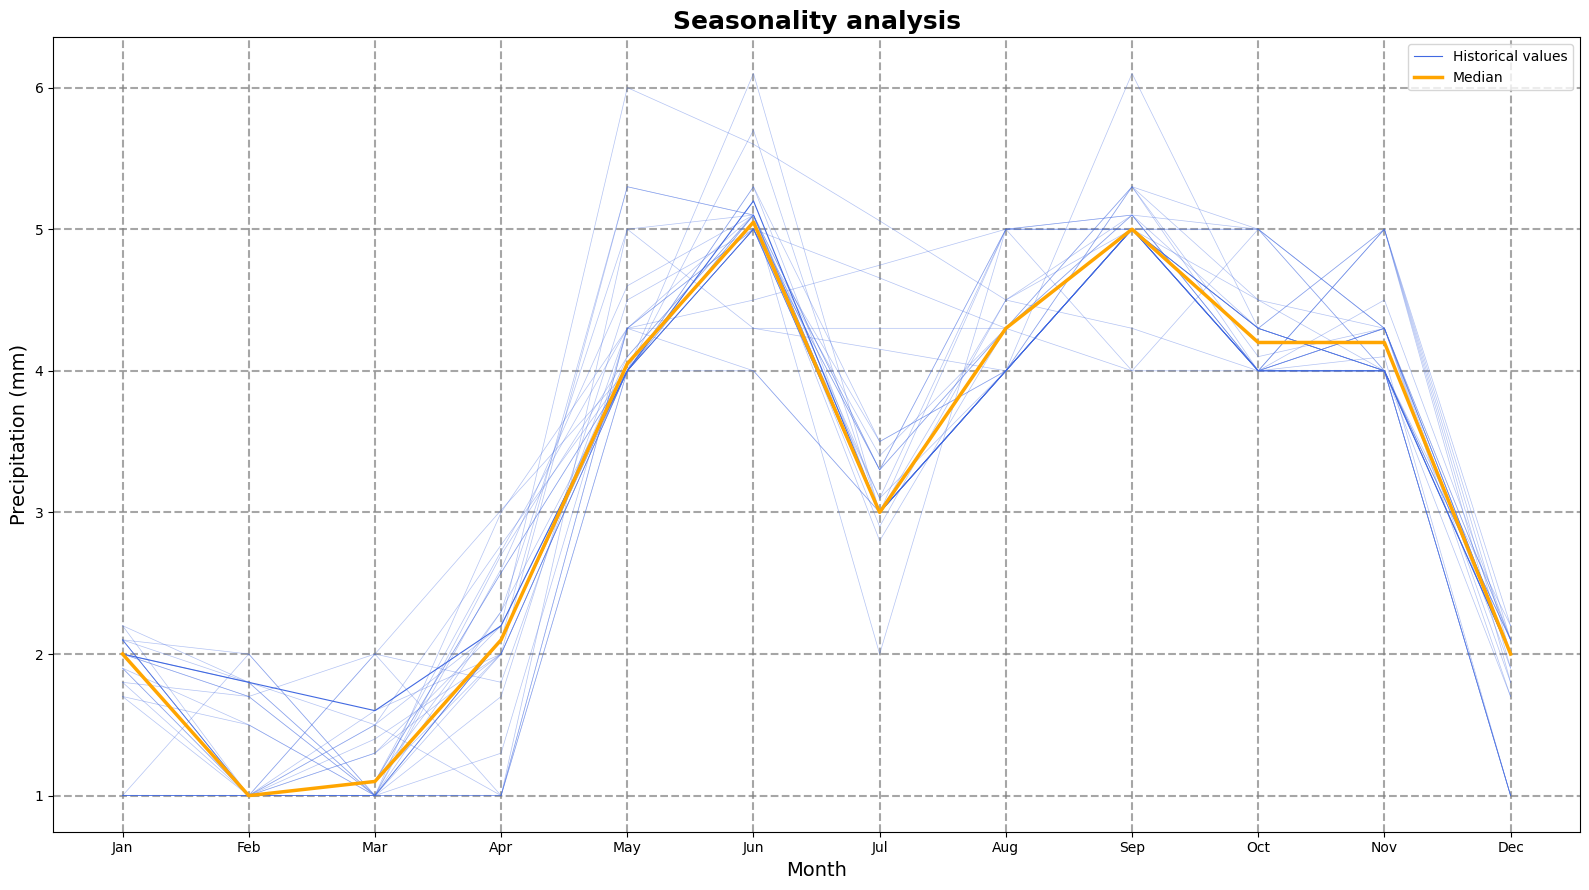

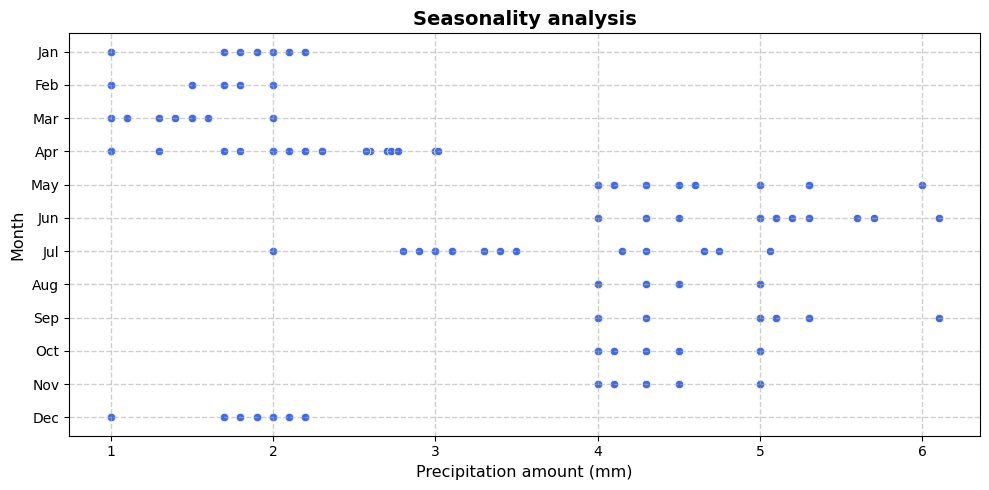

In [10]:
analyze_seasonality(df)

### Stationarity 


In [75]:
def adf_test(timeseries):
    print('Results of the Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            'Test Statistic',
            'p-value',
            'Lags Number',
            'Number of Observation Used'
        ]
    )
    
    # Interpretation
    if dftest[1] < 0.01:
        print("We reject the null hypothesis: the series is stationary.")
    else:
        print("The null hypothesis is not rejected: the series has a unit root and is non-stationary.")
        
    return dfoutput

In [76]:
adf_test(df['precipitation'])

Results of the Dickey-Fuller Test:
The null hypothesis is not rejected: the series has a unit root and is non-stationary.


Test Statistic                 -2.368781
p-value                         0.150742
Lags Number                    11.000000
Number of Observation Used    348.000000
dtype: float64

**General interpretation**: The null hypothesis that the series has a unit root is not rejected, that is, there is not enough evidence to state that the series is stationary.


### Periodicity


In [92]:

# Análisis de periodicidad
def check_periodicity(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)  

    # Calculate the expected date for the next month
    df['Next_month_time'] = df.index + pd.offsets.MonthBegin(1)

    # Calculate the difference excluding the last sample
    df['Difference'] = df['Next_month_time'].shift(1) - df.index

    # Filter non-null differences (excluding the first value which is NaN due to the shift)
    inconsistencies = df[df['Difference'] != pd.Timedelta(0)].dropna(subset=['Difference'])

    if inconsistencies.empty:
        print("All precipitation samples have been taken at 1-month intervals.")
    else:
        print("There are inconsistent time intervals in the precipitation samples.")
        print("Inconsistencies found:")
        print(inconsistencies[['Next_month_time', 'Difference']])
    
    return inconsistencies

In [93]:
check_periodicity(df)

There are inconsistent time intervals in the precipitation samples.
Inconsistencies found:
                                            Next_month_time  \
1970-01-01 00:00:00.000000001 1970-02-01 00:00:00.000000001   
1970-01-01 00:00:00.000000002 1970-02-01 00:00:00.000000002   
1970-01-01 00:00:00.000000003 1970-02-01 00:00:00.000000003   
1970-01-01 00:00:00.000000004 1970-02-01 00:00:00.000000004   
1970-01-01 00:00:00.000000005 1970-02-01 00:00:00.000000005   
...                                                     ...   
1970-01-01 00:00:00.000000355 1970-02-01 00:00:00.000000355   
1970-01-01 00:00:00.000000356 1970-02-01 00:00:00.000000356   
1970-01-01 00:00:00.000000357 1970-02-01 00:00:00.000000357   
1970-01-01 00:00:00.000000358 1970-02-01 00:00:00.000000358   
1970-01-01 00:00:00.000000359 1970-02-01 00:00:00.000000359   

                                              Difference  
1970-01-01 00:00:00.000000001 30 days 23:59:59.999999999  
1970-01-01 00:00:00.000000002 30 d

,date,year,month_name,precipitation,month,Next_month_time,Difference
1970-01-01 00:00:00.000000001,1991-02-01,1991,Feb,1.8,2,1970-02-01 00:00:00.000000001,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000002,1991-03-01,1991,Mar,1.6,3,1970-02-01 00:00:00.000000002,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000003,1991-04-01,1991,Apr,2.2,4,1970-02-01 00:00:00.000000003,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000004,1991-05-01,1991,May,4.0,5,1970-02-01 00:00:00.000000004,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000005,1991-06-01,1991,Jun,5.2,6,1970-02-01 00:00:00.000000005,30 days 23:59:59.999999999
...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000000355,2020-08-01,2020,Aug,4.0,8,1970-02-01 00:00:00.000000355,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000356,2020-09-01,2020,Sep,5.0,9,1970-02-01 00:00:00.000000356,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000357,2020-10-01,2020,Oct,4.0,10,1970-02-01 00:00:00.000000357,30 days 23:59:59.999999999
1970-01-01 00:00:00.000000358,2020-11-01,2020,Nov,4.0,11,1970-02-01 00:00:00.000000358,30 days 23:59:59.999999999


### Homogeneity


In [82]:
def analyze_homogeneity(data_series):
    result_snht = hg.snht_test(data_series)

    # Get test statistics
    loc = result_snht.cp         # Change point date (eg: '1991-04-01')
    mu1 = result_snht.avg.mu1    # Average before the change
    mu2 = result_snht.avg.mu2    # Average after the change
    
    # Plot the precipitation series
    data_series.plot(label='Precipitation', color='royalblue')

    # Horizontal lines (using dates)
    plt.hlines(mu1, 
               xmin=data_series.index.min(),  
               xmax=pd.to_datetime(loc),       
               linestyles='--', lw=2, colors='orange', 
               label=f'mu1: {round(mu1, 2)}')

    plt.hlines(mu2, 
               xmin=pd.to_datetime(loc),       
               xmax=data_series.index.max(),  
               linestyles='--', colors='g', lw=2, 
               label=f'mu2: {round(mu2, 2)}')

    # Vertical line of the change point 
    plt.axvline(x=pd.to_datetime(loc), 
                linestyle='--', color='red', lw=2,
                label=f'Change point: {loc}\np-value: {result_snht.p}')

    plt.title('Homogeneity analysis', fontsize=18)
    plt.xlabel('Years')
    plt.ylabel('Precipitation amount (mm)')
    plt.legend(loc='upper right', fontsize=12)
    plt.grid(color='gray', linestyle='--', linewidth=1.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

    result_snht= pd.Series({
        'Change Point': result_snht.cp,
        'p-value': result_snht.p,
        'Is Homogeneous': not result_snht.h,
        'Mean Before Change (μ1)': result_snht.avg.mu1,
        'Mean After Change (μ2)': result_snht.avg.mu2,
        'Test Statistic': getattr(result_snht, 'T', 'N/A'),
        'Critical Value': getattr(result_snht, 'critical_value', 'N/A')
    }) 
    
    return result_snht

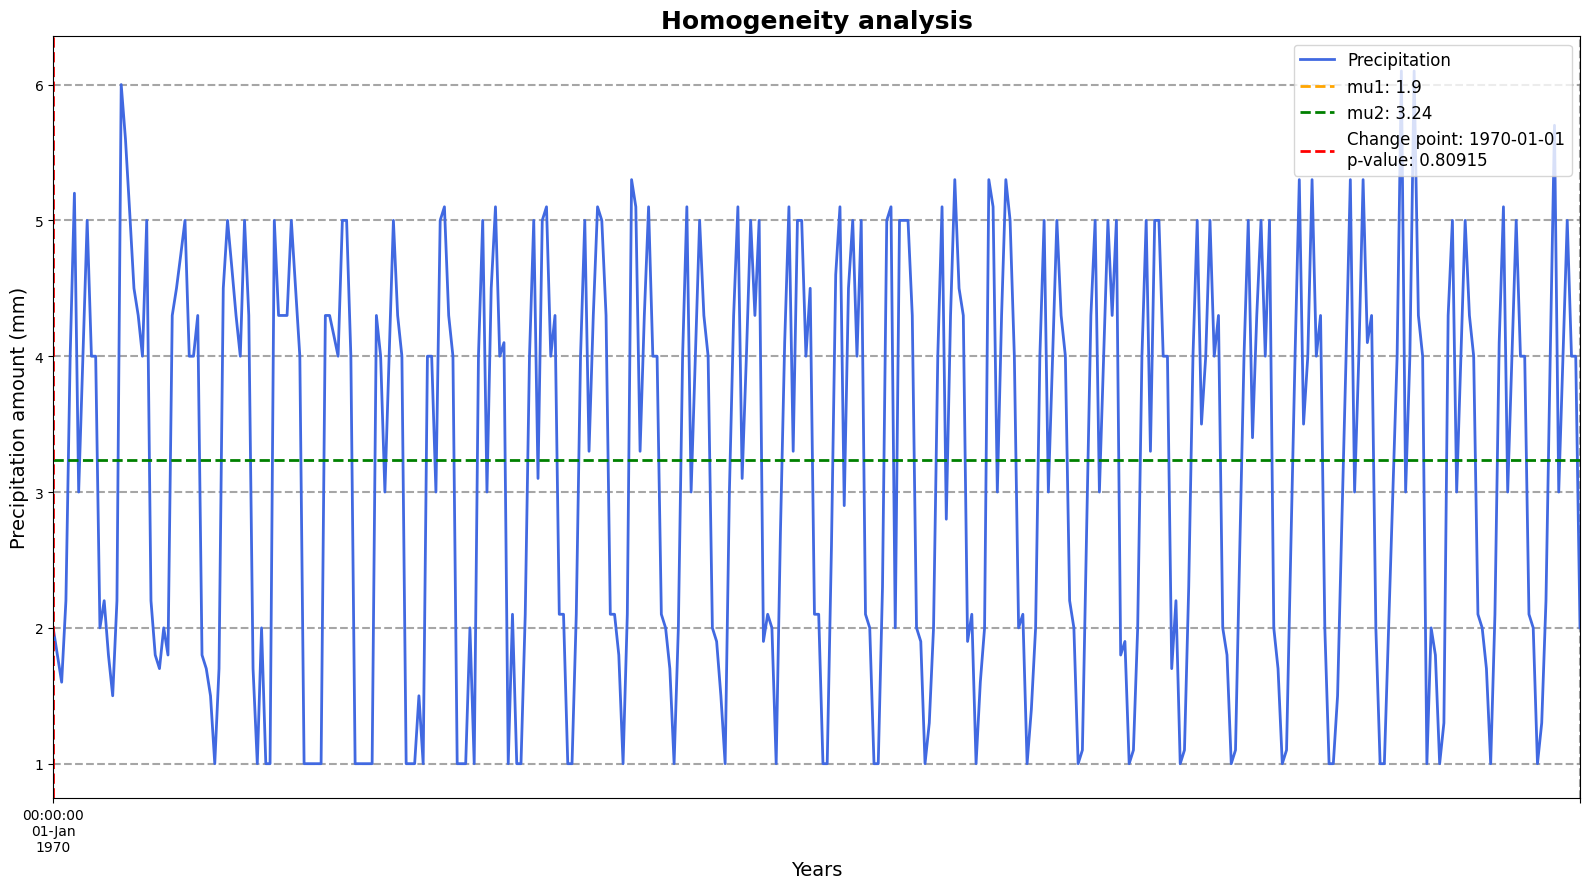

Change Point               1970-01-01
p-value                       0.80915
Is Homogeneous                   True
Mean Before Change (μ1)           1.9
Mean After Change (μ2)        3.23532
Test Statistic               3.170064
Critical Value                    N/A
dtype: object

In [84]:
analyze_homogeneity(df['precipitation'])

**General Interpretation:**


Since no statistically significant change was detected in the time series (based on h=False and a high p-value), it can be concluded that the series is homogeneous.


### Non-linearity


In [86]:
def bds_test(timeseries, alpha):
    print('Results of the BDS Test:')
    dftest = bds(timeseries)

    bds_results = pd.Series({
        'Test Statistic': dftest[0],
        'p-value': dftest[1],
        'Significance Level (α)': alpha,
        'Is Non-linear': dftest[1] < alpha
    })

    if dftest[1] < alpha:               #compare p-value with significance level 
        print('The series is non-linear')
    else:
        print('The series appears to be linear') 
    return bds_results

bds_test(df['precipitation'], 0.01) #set a significance level of 0.01

Results of the BDS Test:
The series is non-linear


Test Statistic                29.095726815260896
p-value                   4.065787252981372e-186
Significance Level (α)                      0.01
Is Non-linear                               True
dtype: object

### Series complexity: autocorrelation

In [87]:
def analyze_autocorrelation(data_series, alpha=0.01, lags=1):
    plot_acf(data_series, alpha=alpha, lags=lags)
    plt.title('Autocorrelation')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(linewidth=1.5, alpha=0.7)
    plt.show()

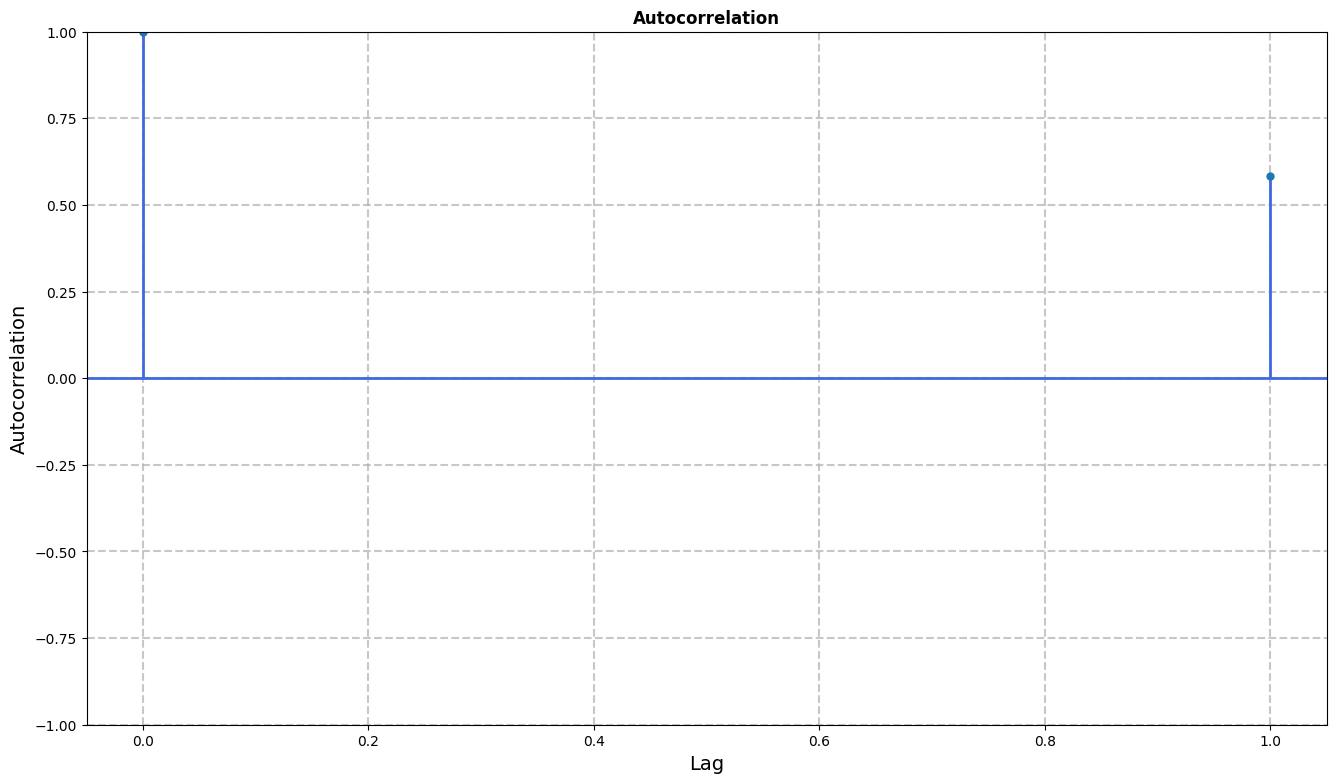

In [88]:
analyze_autocorrelation (df['precipitation'])